<a href="https://colab.research.google.com/github/sebastianbellittieri/sebabellittieri/blob/main/NLP_bert_abstracts_%2B_Clustering_%2B_Forecasts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install lxml
!pip install bertopic
!pip install --ignore-installed tbb
!pip install tf-keras
!pip install pyLDAvis --user
!pip install sentence_transformers
!pip install umap --upgrade --user
!pip install nltk
!pip install hdbscan


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)

In [ ]:
!pip install daal==2021.4.0

     ---------------------------------------- 69.0/69.0 MB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade numpy==1.24.2

In [ ]:
!pip install nltk

In [ ]:
import numpy
numpy.version.version

'1.26.3'

In [ ]:
!pip install umap-learn hdbscan

In [5]:
# import libraries

import os
import xml.etree.ElementTree as ET

import re
import pandas as pd

import numpy as np
import numpy.random.mtrand as mtrand
import nltk
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from umap import UMAP
#import umap.umap_ as umap
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer



/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Introduction:

In this notebook I will show how we can model topics from a set of academic papers from NSF Research Awards. I have a sample of more than 13159 abstracts files from a variety of subjects. I will use an unsupervised model to classify these abstracts into topics.

I have chosen BERTopic model in orden to produce an acceptable outcome for this process and being able to explain every part of my procedure. I could have used LLM's but I have found 2 main issues regarding LLM's for this particular task: the first was related to the costs of working with LLMs (with exception of LLAMA2 of course) and the other important aspect is that in a certain aspect LLMs work as a "black box". I have selected BERTopic because it has the power of a transformer model that uses word embeddings and this text vertorization makes possible to locate semantic similar words and also supports UMAP for dimension
reduction and HDBSCAN for document clustering and I can explain these concepts though a technical interview.

I have based my research for this job in a paper that compares BERTopic, LDA, NMF and Top2Vec. Egger and Yu (2022):  

"Egger R and Yu J (2022) A Topic
Modeling Comparison Between LDA,
NMF, Top2Vec, and BERTopic to
Demystify Twitter Posts.
Front. Sociol. 7:886498.
doi: 10.3389/fsoc.2022.88649"

I wrote all the explanations and most of all functions in English. We can discuss the techniques and the results either in English or Spanish.



## Data pre-view:

I have manually selected a sample of these xml files and explored before collecting data in a massive way. One example of this data is shown below:

'''

This XML file does not appear to have any style information associated with it. The document tree is shown below.
<rootTag>
<Award>
<AwardTitle>
<![CDATA[ Collaborative Research: Excellence in Research: Impact of Gbx2 on neural crest cells during neuronal, craniofacial and cardiovascular development ]]>
</AwardTitle>
<AGENCY>NSF</AGENCY>
<AwardEffectiveDate>07/01/2020</AwardEffectiveDate>
<AwardExpirationDate>06/30/2025</AwardExpirationDate>
<AwardTotalIntnAmount>229338.00</AwardTotalIntnAmount>
<AwardAmount>345460</AwardAmount>
<AwardInstrument>
<Value>Standard Grant</Value>
</AwardInstrument>
<Organization>
<Code>08090100</Code>
<Directorate>
<Abbreviation>BIO</Abbreviation>
<LongName>Direct For Biological Sciences</LongName>
</Directorate>
<Division>
<Abbreviation>IOS</Abbreviation>
<LongName>Division Of Integrative Organismal Systems</LongName>
</Division>
</Organization>
<ProgramOfficer>
<SignBlockName>Philip Becraft</SignBlockName>
<PO_EMAI>pbecraft@nsf.gov</PO_EMAI>
<PO_PHON>7032922477</PO_PHON>
</ProgramOfficer>
<AbstractNarration>Head and heart development are closely intertwined during embryonic development in vertebrates. They share molecular regulatory mechanism as well as some progenitor cell populations. Both head and heart, are made from a multitude of cells, which include mesodermal cells that form musculature and neural crest cells which form connective tissue. Mesodermal and neural crest cells are also important for the development of cartilages and bones in head and neck and for proper septation of the heart. The identity of cells that constitute these tissues is specified very early during embryogenesis via a specific set of genes (specifiers), then follow their trajectory to become muscle, connective tissue, etc.<br/>One early specifier, gastrulation-brain-homeobox 2 (Gbx2), is essential for the migration (movement) and survival of neural crest cells. Neural crest cells and mesodermal cells interact during their migration to form head and heart structures. While mesodermal cells are not directly effected by change in Gbx2 expression, neural crest cells are effected and will alter the communication with mesodermal cells, leading to changes in mesoderm derived structures (e.g., muscles). This project aims to understand how Gbx2 guides neural crest development, and how changes in Gbx2 expression influences head (muscle, cartilage, bone, cranial nerve) and heart development. <br/>Traditionally the fields of comparative, developmental and evolutionary biology have been unsuccessful in recruiting students and scientists of diverse backrounds. This project will promote collaborations between researchers from non-traditional backgrounds in these areas of biology and historically black universities, Howard University and University of the District of Columbia. This award is funded by the NSF Excellence in Research Program.<br/><br/><br/>Technical paragraph<br/>Cranial neural crest cells (CNCCs) are involved in the development of cranial ganglia, cranial nerves, cranium, connective tissue of head muscles, heart septation, pharyngeal arch artery development, etc. The gastrulation-brain-homeobox (Gbx) transcription factor family member, Gbx2, regulates diverse developmental processes, including anteroposterior patterning within the anterior hindbrain and migration and survival of CNCCs. Since CNCCs are involved in many different developmental processes during head and heart development, this project aims to analyze target genes under direct control of Gbx2, that regulate migration and survival of CNCCs in homozygous Gbx2neo embryos. Furthermore, this project will include analyses of the impact of changes of Gbx2 expression on the morphogenesis of the neural system, and craniofacial and cardiovascular structures. The latter part is of significance as neural crest cells influence the development and differentiation of surrounding tissues and vice versa. During head and haert development the interaction of CNCCs and mesoderm is of particular interest for this project because the mesodermal progenitor cells for most of the head and heart musculature derives from a common progenitor field, called the cardiopharyngeal field. In case Gbx2 is somehow involved in the gene regulatory network underlying the differentiation of that mesodermal progenitor field, directly via altering the transcription of genes or indirectly via altering the neural crest - mesodermal interaction during development, this project will lead to insights into mechanisms regulating head and heart development as well as cranial ganglia and nerve development.<br/><br/>This award reflects NSF's statutory mission and has been deemed worthy of support through evaluation using the Foundation's intellectual merit and broader impacts review criteria.</AbstractNarration>
<MinAmdLetterDate>06/29/2020</MinAmdLetterDate>
<MaxAmdLetterDate>08/03/2021</MaxAmdLetterDate>
<ARRAAmount/>
<TRAN_TYPE>Grant</TRAN_TYPE>
<CFDA_NUM>47.074</CFDA_NUM>
<NSF_PAR_USE_FLAG>1</NSF_PAR_USE_FLAG>
<FUND_AGCY_CODE>4900</FUND_AGCY_CODE>
<AWDG_AGCY_CODE>4900</AWDG_AGCY_CODE>
<AwardID>2000005</AwardID>
<Investigator>
<FirstName>Janine</FirstName>
<LastName>Ziermann-Canabarro</LastName>
<PI_MID_INIT>M</PI_MID_INIT>
<PI_SUFX_NAME/>
<PI_FULL_NAME>Janine M Ziermann-Canabarro</PI_FULL_NAME>
<EmailAddress>
<![CDATA[ janine.ziermann@howard.edu ]]>
</EmailAddress>
<NSF_ID>000688985</NSF_ID>
<StartDate>06/29/2020</StartDate>
<EndDate/>
<RoleCode>Principal Investigator</RoleCode>
</Investigator>
<Institution>
<Name>
<![CDATA[ Howard University ]]>
</Name>
<CityName>WASHINGTON</CityName>
<ZipCode>200590002</ZipCode>
<PhoneNumber>2028064759</PhoneNumber>
<StreetAddress>
<![CDATA[ 2400 6TH ST NW ]]>
</StreetAddress>
<StreetAddress2/>
<CountryName>United States</CountryName>
<StateName>District of Columbia</StateName>
<StateCode>DC</StateCode>
<CONGRESSDISTRICT>00</CONGRESSDISTRICT>
<CONGRESS_DISTRICT_ORG>DC00</CONGRESS_DISTRICT_ORG>
<ORG_UEI_NUM>DYZNJGLTHMR9</ORG_UEI_NUM>
<ORG_LGL_BUS_NAME>HOWARD UNIVERSITY</ORG_LGL_BUS_NAME>
<ORG_PRNT_UEI_NUM/>
</Institution>
<Performance_Institution>
<Name>
<![CDATA[ Howard University College of Medicine ]]>
</Name>
<CityName>Washington</CityName>
<StateCode>DC</StateCode>
<ZipCode>200590001</ZipCode>
<StreetAddress>
<![CDATA[ 520 W St NW, Numa Adams Bldg ]]>
</StreetAddress>
<CountryCode>US</CountryCode>
<CountryName>United States</CountryName>
<StateName>District of Columbia</StateName>
<CountryFlag>1</CountryFlag>
<CONGRESSDISTRICT>00</CONGRESSDISTRICT>
<CONGRESS_DISTRICT_PERF>DC00</CONGRESS_DISTRICT_PERF>
</Performance_Institution>
<ProgramElement>
<Code>070Y00</Code>
<Text>HBCU-EiR - HBCU-Excellence in</Text>
</ProgramElement>
<ProgramReference>
<Code>102Z</Code>
<Text>COVID-Disproportionate Impcts Inst-Indiv</Text>
</ProgramReference>
<ProgramReference>
<Code>1119</Code>
<Text>ANIMAL DEVELOPMENTAL MECHANSMS</Text>
</ProgramReference>
<ProgramReference>
<Code>1228</Code>
<Text>MINORITY INVOLVEMENT -- BIO</Text>
</ProgramReference>
<ProgramReference>
<Code>1594</Code>
<Text>HIST BLACK COLLEGES AND UNIV</Text>
</ProgramReference>
<ProgramReference>
<Code>2886</Code>
<Text>MINORITY INSTITUTIONS PROGRAM</Text>
</ProgramReference>
<ProgramReference>
<Code>9178</Code>
<Text>UNDERGRADUATE EDUCATION</Text>
</ProgramReference>
<Appropriation>
<Code>0120</Code>
<Name>NSF RESEARCH & RELATED ACTIVIT</Name>
<APP_SYMB_ID>040100</APP_SYMB_ID>
</Appropriation>
<Appropriation>
<Code>0121</Code>
<Name>NSF RESEARCH & RELATED ACTIVIT</Name>
<APP_SYMB_ID>040100</APP_SYMB_ID>
</Appropriation>
<Fund>
<Code>01002021DB</Code>
<Name>
<![CDATA[ NSF RESEARCH & RELATED ACTIVIT ]]>
</Name>
<FUND_SYMB_ID>040100</FUND_SYMB_ID>
</Fund>
<Fund>
<Code>01002122DB</Code>
<Name>
<![CDATA[ NSF RESEARCH & RELATED ACTIVIT ]]>
</Name>
<FUND_SYMB_ID>040100</FUND_SYMB_ID>
</Fund>
<FUND_OBLG>2020~229338</FUND_OBLG>
<FUND_OBLG>2021~116122</FUND_OBLG>
</Award>
</rootTag>
'''

In this code there is a key that allows us to extract the abstract: "AbstractNarration". We will extract this texts in order to create embeddings and process the topic model with this key.


## Data Collection:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:


def leer_archivo_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    return root

def recopilar_informacion(directorio):
    datos_recopilados = []

    for archivo in os.listdir(directorio):
        if archivo.endswith(".xml"):
            file_path = os.path.join(directorio, archivo)
            root = leer_archivo_xml(file_path)


            for item in root.findall('.//AbstractNarration'): # we append texts from Abstracts
                datos_recopilados.append(item.text)

    return datos_recopilados

# Define el directorio
directorio_xml = '/content/drive/MyDrive/BERT/2020.zip (Unzipped Files)'

# Llama a la función para recopilar información
informacion = recopilar_informacion(directorio_xml)

abstracts_crudos = informacion

## Data Preprocessing:

In [7]:


# Limitar hilos de bibliotecas numéricas
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# Descarga recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Preprocesamiento de Texto
def preprocesar_texto(texto):
    if not texto or not isinstance(texto, str):
        return ""

    # Convertir a minúsculas
    texto = texto.lower()
    # Remover puntuación
    texto = re.sub(r'\W', ' ', texto)
    # Tokenización
    tokens = nltk.word_tokenize(texto) # dividing strings into lists of substrings
    # Remover stopwords y lematización
    stopwords = set(nltk.corpus.stopwords.words('english')) # for paragraphs in orden to be processed.
    lemmatizer = nltk.WordNetLemmatizer() # to get te roots of each word using WordNet.
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords]

    return ' '.join(tokens)


# Cargar datos
abstracts = abstracts_crudos

# Filtrar valores None o vacíos
abstracts = [abstract for abstract in abstracts if abstract and isinstance(abstract, str)]

# Preprocesar resúmenes
abstracts_preprocesados = [preprocesar_texto(abstract) for abstract in abstracts]

# Filtrar resúmenes preprocesados vacíos
abstracts_preprocesados = [abstract for abstract in abstracts_preprocesados if abstract]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## Data Modeling:

In [8]:
# Pre calculate Embeddings:

'''
It is a good practice to pre-calculate embeddings. It will make the rest of the process faster, and since this is
a fixed sample of documents it will be in a certain way "static info".

'''



# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(abstracts_preprocesados, show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/412 [00:00<?, ?it/s]

In [9]:
# prevent stochastic behaviour:

'''
In BERTopic, we generally use a dimensionality reduction algorithm to reduce the size of the embeddings.
This is done to prevent the curse of dimensionality to a certain degree.

As a default, this is done with UMAP which is an incredible algorithm for reducing dimensional space.
However, by default, it shows stochastic behavior which creates different results each time you run it.
To prevent that, we will need to set a random_state of the model before passing it to BERTopic.

n_neighbors: This determines the number of neighboring points used in local approximations of manifold structure.
Larger values will result in more global structure being preserved at the loss of detailed local structure.
In general this parameter should often be in the range 5 to 50, with a choice of 10 to 15 being a sensible default.

min_dist: This controls how tightly the embedding is allowed compress points together.
Larger values ensure embedded points are more evenly distributed, while smaller values allow the algorithm to
optimise more accurately with regard to local structure. Sensible values are in the range 0.001 to 0.5, with 0.1
being a reasonable default.

'''



umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.1,metric='cosine',random_state=42)

In [10]:
# adding a representation model in this case I choose keyBERTInspired



# KeyBERT
representation_model = KeyBERTInspired()


In [11]:
# controlling the number of topics:



hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [12]:
# Adding a vectorize model:


vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 3))

In [13]:


# topic_model=BERTopic(embedding_model='all-MiniLM-L6-v2') # this is the embedding model that work well with english texts.
# topics,probs=topic_model.fit_transform(abstracts_preprocesados) # veamos si funciona sin preprocesar...

topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  hdbscan_model=hdbscan_model,
  umap_model=umap_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(abstracts_preprocesados, embeddings)


2024-07-23 01:27:47,895 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-23 01:28:36,026 - BERTopic - Dimensionality - Completed ✓
2024-07-23 01:28:36,029 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-23 01:28:36,878 - BERTopic - Cluster - Completed ✓
2024-07-23 01:28:36,907 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-23 01:33:24,296 - BERTopic - Representation - Completed ✓


In [14]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,4903,-1_support evaluation using_evaluation using f...,"[support evaluation using, evaluation using fo...",[increasing number computer science graduate n...
1,0,395,0_covid 19 pandemic_spread covid 19_covid 19_1...,"[covid 19 pandemic, spread covid 19, covid 19,...",[emerging infectious disease outbreak current ...
2,1,321,1_algebraic geometry_geometry_mathematics_geom...,"[algebraic geometry, geometry, mathematics, ge...",[representation theory branch algebra studying...
3,2,235,2_support evaluation using_innovation research...,"[support evaluation using, innovation research...",[broader impact commercial potential small bus...
4,3,128,3_future stem worker_academic success retentio...,"[future stem worker, academic success retentio...",[project contribute national need well educate...
...,...,...,...,...,...
230,229,10,229_random matrix theory_theory random matrix_...,"[random matrix theory, theory random matrix, r...",[research project focus two fundamental notion...
231,230,10,230_major research instrumentation_material re...,"[major research instrumentation, material rese...",[grand challenge field material science soft m...
232,231,10,231_million herbarium specimen_herbarium colle...,"[million herbarium specimen, herbarium collect...",[herbarium archival scientific collection pres...
233,232,10,232_information searching_information retrieva...,"[information searching, information retrieval,...",[people often difficulty expressing informatio...


In [19]:
'''
probabilities_List[float] <-The probability of the assigned topic per document.
These are only calculated if a HDBSCAN model is used for the clustering step.
When calculate_probabilities=True, then it is the probabilities of all topics per document.


'''

probs[1] # the probability of the assigned topic for abstract #3 is 0.968

0.7702900769356013

In [20]:
len(abstracts_preprocesados)

# this is the number of preprocessed corpuses

13159

## Data Analysis:

In [21]:
topic_model.get_topic(-1)

[('support evaluation using', 0.2818917),
 ('evaluation using foundation', 0.2746834),
 ('broader impact review', 0.27340537),
 ('nsf statutory mission', 0.25172678),
 ('support evaluation', 0.24988127),
 ('engineering', 0.24357471),
 ('worthy support evaluation', 0.24152765),
 ('merit broader impact', 0.23839699),
 ('broader impact', 0.22689606),
 ('research', 0.2257098)]

Here we can see the outliers from this topic model. As espected those are words or fragments of words appearing in a general way in many documents and are not specific for a topic classification.

There are ways to diminish this outliers and tend to classificate every document. One way is to use the topics found on the first calibration.

In [22]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(abstracts_preprocesados, topics)

# Reduce outliers with pre-calculate embeddings instead
# new_topics = topic_model.reduce_outliers(abstracts, topics, strategy="embeddings", embeddings=embeddings)


100%|██████████| 5/5 [00:41<00:00,  8.21s/it]


With the code to reduce outliers we can assign a topic to all abstracts wich were identified with the outliers topics within the other well classified topics. It may have the weakness of loosing precision but it is an important aspect to evaluate.

In [23]:
topic_model.get_topic(0)

[('covid 19 pandemic', 0.5833298),
 ('spread covid 19', 0.4808188),
 ('covid 19', 0.4788169),
 ('19 pandemic', 0.44440365),
 ('spread covid', 0.44297504),
 ('pandemic', 0.43333054),
 ('covid', 0.43092468),
 ('coronavirus', 0.42826068),
 ('outbreak', 0.36930943),
 ('public health', 0.36026633)]

The  topic inferred by the model is related to research about COVID 19. It has a clear interpretation and this model identifies 395 papers related to this topic. Note that this result depends on model's stochastic behaviour and the setting of an specific seed to avoid different results.

In [24]:
topic_model.get_representative_docs(0)


['emerging infectious disease outbreak current novel coronavirus covid 19 pandemic mathematical model important tool help inform public health recommendation best utilization limited resource research develop analyze data driven mathematical model predict spread evaluate success various public health intervention strategy control covid 19 u abroad model account characteristic pathogen variation transmission occur within community hospital setting geographical difference transmission broader impact model provide real time information assist public health official decision maker making critical decision covid 19 control policy resource allocation br br standard modeling approach compartmental population based approach may suitable modeling spread covid 19 due high level heterogeneity system disease pathway population makeup host interaction different level organization household workplace school social activity adaptive feature human behavior investigator employ individual based modeling

As shown above all the abstracts are related to COVID 19 disease and associated aspects.

In [25]:
data_frame_results=pd.DataFrame({'Topic':new_topics, 'Document':abstracts_preprocesados})


In [26]:
data_frame_results

,Topic,Document
0,112,hydrothermal liquefaction htl considered promi...
1,7,glioblastoma multiforme gbm deadliest form bra...
2,201,faculty early career development program caree...
3,54,project advance fundamentally new control fram...
4,7,grant support research advance knowledge manuf...
...,...,...
13154,1,nsf award provides funding project develop new...
13155,33,transport mixing play central role circulation...
13156,33,project concern development mathematical techn...
13157,33,euler equation introduced 1755 provide basic m...


Another way to concentrate this information is using Pandas. In the preceding dataframe is a sample o 10 abstract documents and their corresponding topic according to BERT model.

In [27]:
fig=topic_model.visualize_topics()

# Ajustar el tamaño de la figura
fig.update_layout(
    width=1000,  # Ancho del gráfico
    height=600,  # Altura del gráfico

)

# Mostrar el gráfico
fig.show()

Here we can see how out model has classificated these abstracts into particular topics and group them according to semantic similarity. There are 2 main components of dimensionality in the graph and every cluster has it own relative distance to others. The size of the cluters indicate the number of abstracts that were grouped on thar particular topic and coincidence of position shows that different groups are strongly related by the model, for example: Topic 1 and Topic 217.

In [28]:
topic_model.visualize_barchart()



These barcharts represents the scores of each word in each topic

In [29]:
topic_model.visualize_term_rank()

In the term score decline per topic we can observate how TF-IDF wich is a measure to evaluate the importance of a word in a collection of documents decays in each topic showing the relative importance of the word in the topic. Topics with the "flattests" graphics have higher indifference to words in their respective keys.

In [30]:
topic_model.visualize_hierarchy()

In the above dentrogram is shown how topics are agrupated, according to semantic similarity, into groups that constructs hierarchies.This visualization, in particular, aids in finding an appropriate number of k-topics.

At this point this topic classification model classificates 13159 abstracts into 233 topics, clustering embeddings with a size > 10 abstracts per cluster. However, according to the dendrogram we can group this topics in fewer classes attempting to gain generalization.

## Evaluation:

In [31]:
abstracts_preprocesados[0]

'hydrothermal liquefaction htl considered promising thermal processing approach biofuel production broad range organic matter including agricultural waste biomass municipal solid waste algae recent u department energy report stated much 5 9 billion gallon biocrude could produced year u available waste organic matter using htl technology biocrude refined liquid transportation fuel using process similar conventional petroleum refining replacing fuel currently produced non renewable feedstock however current htl process produce large amount wastewater containing high concentration organic compound nutrient sustainable disposal wastewater one significant bottleneck scale commercialization htl research address concern environmental energy conversion efficiency perspective htl recovering organic carbon nutrient htl wastewater critical step increasing net energy yield enhancing economic viability environmental sustainability htl process course carrying project researcher train next generation

In [33]:
topic_model.get_topic(112)

[('biofuel production', 0.51670253),
 ('biofuel', 0.51177406),
 ('microbial fuel', 0.47510466),
 ('wastewater', 0.45659918),
 ('microbial fuel cell', 0.4473393),
 ('wastewater treatment', 0.444228),
 ('waste nitrogen', 0.432959),
 ('municipal solid waste', 0.40861654),
 ('waste water', 0.3576759),
 ('microbial', 0.3418122)]

# Second problem: Birgmingham Credit Card transactions

## Introduction:

In the url https://www.cityobservatory.birmingham.gov.uk/@birmingham-city-council/purchase-card-transactions is located a group of excel spreadsheets that contain data about public corporate purchases (with credit cards) in the city of Birmingham. It has monthly data from April 2014 to June 2024.

I have chosen to work with data from August 2021 to August 2022 since there is a missing spreadsheet in the year 2023 and I have assumed that this issue could lead to problemns with forecasting. I will perform a cluster analysis with the objective of discovering profiles.   



## Import the xlsx files

In [34]:
import pandas as pd
import os
import requests

# Define el directorio donde están tus archivos Excel
directory = '/content/drive/MyDrive/BIRMINGHAM'

# Inicializa una lista vacía para almacenar los DataFrames
dfs = []

# Lee y concatena los archivos Excel
for filename in os.listdir(directory):
    if filename.endswith(".xlsx") or filename.endswith(".xls"):
        file_path = os.path.join(directory, filename)
        df = pd.read_excel(file_path)
        dfs.append(df)




## Data Cleansing and exploration

In [35]:
'''
As we can appreciate in every monthly spreadsheet there were different columns and to process all the information I had
to select all the common columns

'''

print(dfs[2].columns)

print(dfs[3].columns)

Index(['TRANS DATE', 'TRANS TAX DESC', 'ORIGINAL GROSS AMT', 'ORIGINAL CUR',
       'MERCHANT NAME', 'MERCHANT TAX REG NO', 'MCC CODE', 'CARD NUMBER',
       'BILLING CUR CODE', 'TRANS CAC CODE 1', 'TRANS CAC DESC 1',
       'TRANS CAC CODE 2', 'TRANS CAC DESC 2', 'TRANS CAC CODE 3',
       'TRANS CAC DESC 3', 'Directorate'],
      dtype='object')
Index(['TRANS DATE', 'TRANS TAX DESC', 'ORIGINAL GROSS AMT', 'ORIGINAL CUR',
       'BILLING GROSS AMT', 'BILLING CUR CODE', 'TRANS TAX AMT',
       'TRANS ORIGINAL NET AMT', 'MERCHANT NAME', 'CARD NUMBER',
       'TRANS CAC CODE 1', 'TRANS CAC CODE 2', 'TRANS CAC CODE 3',
       'TRANS CAC CODE 4', 'TRANS CAC CODE 5', 'TRANS CAC CODE 6',
       'TRANS CAC CODE 7', 'TRANS CAC CODE 8', 'DIRECTORATE'],
      dtype='object')


In [36]:
'''
I will investigate briefly all these dataframes to get first approaches.

First, these dataframes have not the same number of columns, neither the same names. I will lower the cases of all column
names and fill the blank spaces with _.

Second, I will create a set of columns common in every dataframe and then concat them into a single dataframe.

Third, I think it will be appropriate to remove those columns whose values are all the same.

'''
lista_columns=[]

data_total=pd.DataFrame()

for i in range(0,12):
        dfs[i].columns=dfs[i].columns.str.lower().str.replace(' ','_').str.replace('directorates','directorate')

        lista_columns.append(dfs[i].columns.to_list())


#Selecting all the common columnns and concatenating them in a single data frame:

conjuntos = map(set, lista_columns)
elementos_comunes = set.intersection(*conjuntos)
elementos_comunes = list(elementos_comunes)

for i in range(0,12):
        data_total=pd.concat([data_total,dfs[i][elementos_comunes]],axis=0,ignore_index=True)





In [37]:
# Les see the head of the total dataframe:
data_total.head(10)

,original_gross_amt,trans_cac_code_3,trans_tax_desc,merchant_name,trans_date,billing_cur_code,directorate,trans_cac_code_2,card_number,trans_cac_code_1,original_cur
0,100.00,NaN,VR,vauxhall road fuel exp,2022-07-12,GBP,ADULT SOCIAL CARE,AV0AR,************6208,B1,GBP
1,40.63,NaN,VR,vauxhall road fuel exp,2022-07-15,GBP,ADULT SOCIAL CARE,AV0AR,************6208,B1,GBP
2,75.54,NaN,VR,vauxhall road fuel exp,2022-07-15,GBP,ADULT SOCIAL CARE,AV0AR,************6208,B1,GBP
3,280.00,NaN,VR,med - pts ambulance se,2022-07-08,GBP,ADULT SOCIAL CARE,AV0AN,************9636,B1,GBP
4,318.00,NaN,VR,amznmktplace,2022-07-27,GBP,ADULT SOCIAL CARE,AV0AN,************9636,B1,GBP
5,13.99,NaN,VR,uber eats,2022-08-01,GBP,ADULT SOCIAL CARE,AV0AN,************9636,B1,GBP
6,300.00,NaN,VR,med - pts ambulance se,2022-07-22,GBP,ADULT SOCIAL CARE,AV0BA,************3982,B1,GBP
7,99.08,3A01,VR,weoley castle,2022-07-11,GBP,ADULT SOCIAL CARE,AV0AR,************0140,B1,GBP
8,99.95,3A01,VR,weoley castle,2022-07-15,GBP,ADULT SOCIAL CARE,AV0AR,************0140,B1,GBP
9,100.00,3A01,VR,weoley castle,2022-08-02,GBP,ADULT SOCIAL CARE,AV0AR,************0140,B1,GBP


In [38]:
# See the information about each Feature:

data_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44461 entries, 0 to 44460
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   original_gross_amt  44461 non-null  float64       
 1   trans_cac_code_3    38024 non-null  object        
 2   trans_tax_desc      43833 non-null  object        
 3   merchant_name       44461 non-null  object        
 4   trans_date          44461 non-null  datetime64[ns]
 5   billing_cur_code    44461 non-null  object        
 6   directorate         44461 non-null  object        
 7   trans_cac_code_2    43967 non-null  object        
 8   card_number         44461 non-null  object        
 9   trans_cac_code_1    44361 non-null  object        
 10  original_cur        44461 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 3.7+ MB


From this dataframe we can observe that "original_gross_amt", "merchant_name", "card_number", "billing_cur_code" "original_cur" and "directorate" columns presents no missing values. The lenght of this dataframe is 44461 values. There is only one nummeric column, related to the ammount of the expenditures, and datetime of all the transactions.

As nominal variables we have "merchant_name", "trans_tax_desc", "trans_cac_code_1", "trans_cac_code_2", "trans_cac_code_3", "card_number", "billing_cur_code", "original_cur" and "directorate". In the next steps I will evaluate if all these variables have a clear meaning because there was not a dataframe variable description available in the page.

In [39]:
data_total.columns

Index(['original_gross_amt', 'trans_cac_code_3', 'trans_tax_desc',
       'merchant_name', 'trans_date', 'billing_cur_code', 'directorate',
       'trans_cac_code_2', 'card_number', 'trans_cac_code_1', 'original_cur'],
      dtype='object')

In [40]:
# We can see that there are different currencies in the transactions:

data_total.original_cur.unique()

array(['GBP', 'USD', 'EUR', 'AUD', 'RUB', 'PKR', 'DKK', 'NOK', 'PLN',
       'CAD'], dtype=object)

In [41]:
'''
since there are different currecies I have researched a in https://fxds-hcc.oanda.com/ the curencies for year 2022 (July).
I will change the gross amounts considering these exchange rates and then delete 'original_curr' column

'''

# USD * .786 = 1 GBP
# EUR * .854 = 1 GBP
# AUD * .518 = 1 GBP
# RUB * 0.009 = 1 GBP
# PKR * 0.003 = 1 GBP
# DKK * 0.115 =1 GBP
# NOK * 0.075 = 1 GBP
# PLN * 0.195 = 1 GBP
# CAD * 0.582 = 1 GBP
# KRW * 0.001 = 1 GBP

data_total.loc[data_total['original_cur'] == 'USD', 'original_gross_amt'] *= 0.786
data_total.loc[data_total['original_cur'] == 'EUR', 'original_gross_amt'] *= 0.854
data_total.loc[data_total['original_cur'] == 'AUD', 'original_gross_amt'] *= 0.518
data_total.loc[data_total['original_cur'] == 'RUB', 'original_gross_amt'] *= 0.009
data_total.loc[data_total['original_cur'] == 'PKR', 'original_gross_amt'] *= 0.003
data_total.loc[data_total['original_cur'] == 'DKK', 'original_gross_amt'] *= 0.115
data_total.loc[data_total['original_cur'] == 'NOK', 'original_gross_amt'] *= 0.075
data_total.loc[data_total['original_cur'] == 'PLN', 'original_gross_amt'] *= 0.195
data_total.loc[data_total['original_cur'] == 'CAD', 'original_gross_amt'] *= 0.582
data_total.loc[data_total['original_cur'] == 'KRW', 'original_gross_amt'] *= 0.001


In [42]:
# Lets describe the nummeric variable.
data_total.original_gross_amt.describe().round(2)

count    44461.00
mean       139.66
std        614.86
min      -3601.50
25%         16.14
50%         50.00
75%         99.87
max      65180.80
Name: original_gross_amt, dtype: float64

As I stated before the number of transactions is 44461, the mean ammount of transaction is 139.66, with a standard deviation of 632,90. The minimum value is a reversed of funds of 3601.50 GBP, the first quantile is 16.14 GBP, the median 50.00 GBP (wich indicates that there is a skew in this distribution, the 3rd quantile is 99.87 GBP. The max value of these transactions is 65180.80 GBP wich is a large outlier in this distribution.

A boxplot shows the distribution of these values.

<Axes: >

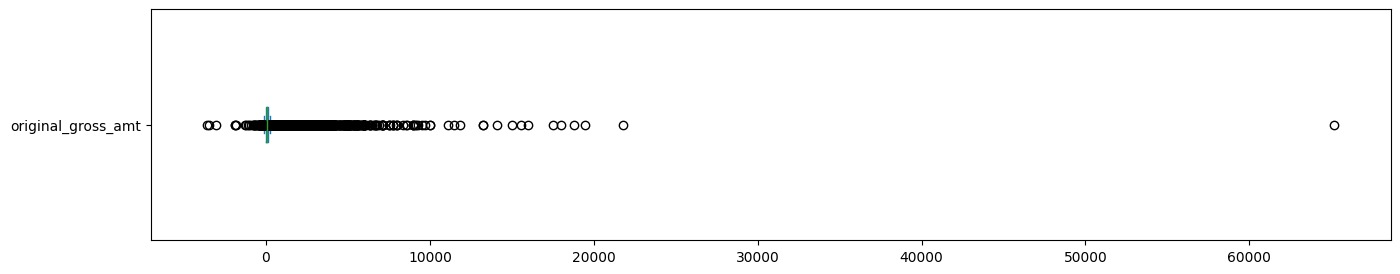

In [43]:
data_total.original_gross_amt.plot(kind='box',vert=False,figsize=(16,3))

In [44]:
data_total[data_total['original_gross_amt']> 3000]['original_gross_amt'].count()

285

As we can appreciate in this boxplot there are al large number of outliers in the transactions and a high leptokurtic distribution of values. There are 285 transactions for more than 3000 GBP.

In [45]:
'''
Now we can clear these columns that have no more relevant information.
'''

data_total.drop(columns='original_cur', inplace=True)
data_total.drop(columns='billing_cur_code', inplace=True)

In [46]:
# Les explore trans_cac_codes and tax descriptions:
print(data_total.trans_cac_code_2.value_counts())
print(data_total.trans_cac_code_1.value_counts())
print(data_total.trans_cac_code_3.value_counts())
print(data_total.trans_tax_desc.value_counts())

trans_cac_code_2
RUF0F    2005
RUB26    1290
REAAB    1214
AV01F     904
AV01C     896
         ... 
RETW2       1
RBL13       1
rbl08       1
RBF14       1
A003A       1
Name: count, Length: 901, dtype: int64
trans_cac_code_1
B1      15294
L100     7582
K020     3254
L220     2521
L080     1733
        ...  
M980        1
L690        1
P060        1
L4H0        1
J3A0        1
Name: count, Length: 107, dtype: int64
trans_cac_code_3
A00     27440
4P00     1396
4A0A     1254
3A01     1165
4A01      972
        ...  
4P01        1
4A03        1
4G06        1
8D10        1
2A07        1
Name: count, Length: 116, dtype: int64
trans_tax_desc
VR           27784
VZ           15037
VL             739
0 Percent      112
VF              93
VE              52
VT               8
VS               5
12.5%            3
Name: count, dtype: int64


With no information regarding this codes there is no possible interpretation about them and I have decided to drop them from data_total.


In [47]:
data_total.drop(columns=['trans_cac_code_2','trans_cac_code_1','trans_tax_desc','trans_cac_code_3'],inplace=True)


In [48]:
#Lets explore the columns card_number, merchant_name and directorate:

print(data_total.merchant_name.value_counts())
print(data_total.card_number.value_counts())
print(data_total.directorate.value_counts())


merchant_name
amznmktplace              7779
parking 1vr               1457
bcc clean air zone        1175
asda groceries online      816
tesco pay at pump 4231     634
                          ... 
amazon.co.uk6o0f55db5        1
rainbow office supplie       1
playshifu technologies       1
paypal theresehoyl           1
amazon.co.uk2c70i4uu4        1
Name: count, Length: 8485, dtype: int64
card_number
************6667    1814
************9032    1001
************0126     535
************0909     444
************1154     414
                    ... 
************6308       1
************2471       1
************5964       1
************6180       1
************2756       1
Name: count, Length: 732, dtype: int64
directorate
SCHOOLS                             23802
NEIGHBOURHOODS                      11915
EDUCATION & SKILLS                   2217
INCLUSIVE GROWTH                     1908
FINANCE AND GOVERNANCE               1827
ADULT SOCIAL CARE                    1676
Digital & Custo

In the preceding columns we can identify clear information even without a dataset description file.

Considering "merchant_name" we have 8394 different values and more than half of these transactions are grouped within the most frecuent 65 values.

Regarding card numbers, as a matter of personal information security, there are only the last 4 digits of every card. In the complete dataset there were 732 different credit cards used (with this criteria of 4 digits). There are more than 10 percent of these transactions (4233) that were made with only 5 credit cards.

About directorates we see clearly that there are some labels to correct and unify.




In [49]:
# Correct the names of directorates:
data_total.directorate=data_total.directorate.apply(lambda x: x.lower())
data_total.directorate=data_total.directorate.apply(lambda x: x.replace(' ','_'))
data_total.loc[data_total['directorate']=='education_&_skills', 'directorate'] ='education_and_skills'
data_total.loc[data_total['directorate']=='inclusive_growth_', 'directorate'] ='inclusive_growth'
data_total.loc[(data_total['directorate']=='digital_&_customer_services_') |
               (data_total['directorate']=='digital_&_customer_services'), 'directorate'] ='digital_and_customer_services'
data_total.loc[data_total['directorate']=='partnership_insight_&_prevention', 'directorate'] ='partnership_insight_and_prevention'

In [50]:
data_total.directorate.value_counts()

directorate
schools                               23802
neighbourhoods                        11987
education_and_skills                   2221
inclusive_growth                       1912
finance_and_governance                 1834
adult_social_care                      1676
digital_and_customer_services           876
partnership_insight_and_prevention       76
strategic_services                       26
commonwealth_games                       24
human_resources                          23
acivico                                   4
Name: count, dtype: int64

In [51]:
data_total.merchant_name.value_counts().head(65).sum()

22353

In [52]:
data_total.card_number.value_counts().head(5).sum()

4208

In [53]:
data_total.directorate.value_counts().head(3).sum()

38010

In [54]:
data_total.columns

Index(['original_gross_amt', 'merchant_name', 'trans_date', 'directorate',
       'card_number'],
      dtype='object')

In [56]:
print(data_total.trans_date.min())
print(data_total.trans_date.max())

2021-05-05 00:00:00
2022-09-02 00:00:00


## Clustering (customer profiles)

By applying RFM analysis and K-means clustering to this dataset, with the objetive of gaining insights into customer behavior and preferences.

RFM Analysis is a simple yet powerful method to quantify customer behavior. It evaluates customers based on three key dimensions:

Recency (R): How recently did a particular customer make a transaction
Frequency (F): How often do they make transactions
Monetary Value (M): How much money do they spend.

I will use the information in the dataset to compute the recency, frequency, and monetary values. Then, I will map these values to the generally used RFM score scale of 1 - 5.

I will try to identify customer segments with similar RFM characteristics. And for this, I will use K-Means clustering, an unsupervised machine learning algorithm that groups similar data points into clusters.

In [57]:
snapshot_date = max(data_total['trans_date']) + pd.DateOffset(days=1)

In [58]:
data_total['transaction_number'] = range(1, len(data_total) + 1)
data_total

,original_gross_amt,merchant_name,trans_date,directorate,card_number,transaction_number
0,100.00,vauxhall road fuel exp,2022-07-12,adult_social_care,************6208,1
1,40.63,vauxhall road fuel exp,2022-07-15,adult_social_care,************6208,2
2,75.54,vauxhall road fuel exp,2022-07-15,adult_social_care,************6208,3
3,280.00,med - pts ambulance se,2022-07-08,adult_social_care,************9636,4
4,318.00,amznmktplace,2022-07-27,adult_social_care,************9636,5
...,...,...,...,...,...,...
44456,6.70,wilko retail limited,2022-06-14,schools,************3302,44457
44457,7.50,wilko retail limited,2022-06-15,schools,************3302,44458
44458,5.00,sainsburys s/mkts,2022-06-16,schools,************3302,44459
44459,8.16,sainsburys s/mkts,2022-06-23,schools,************3302,44460


In [59]:
rfm = data_total.groupby('card_number').agg({
    'trans_date': lambda x: (snapshot_date - x.max()).days,
    'transaction_number': 'nunique',
    'original_gross_amt': 'sum'
})

In [60]:
rfm.rename(columns={'trans_date': 'Recency', 'transaction_number': 'Frequency', 'original_gross_amt': 'MonetaryValue'}, inplace=True)
rfm.head()

,Recency,Frequency,MonetaryValue
card_number,,,
************0031,288,1,99.58
************0037,10,9,3190.39
************0057,43,14,1470.07
************0065,30,100,14075.28
************0085,365,1,120.28


Map RFM Values onto a 1-5 Scale

I will map the “Recency”, “Frequency”, and “MonetaryValue” columns to take on values in a scale of 1-5; one of {1,2,3,4,5}.

I will assign the values to five different bins, and map each bin to a value. To help us fix the bin edges, let’s use the quantile values of the “Recency”, “Frequency”, and “MonetaryValue” columns:

In [61]:
rfm.describe()

,Recency,Frequency,MonetaryValue
count,732.000000,732.000000,732.000000
mean,65.583333,60.739071,8482.886255
std,95.250996,98.865889,27977.988340
min,1.000000,1.000000,-160.800000
25%,9.000000,11.000000,985.425000
50%,25.000000,34.000000,3011.700000
75%,54.000000,83.000000,7478.080000
max,396.000000,1814.000000,423425.530000


In [62]:
# Calculate custom bin edges for Recency, Frequency, and Monetary scores
recency_bins = [rfm['Recency'].min()-1, 9, 24, 52, 200, rfm['Recency'].max()]
frequency_bins = [rfm['Frequency'].min() - 1, 4, 11, 70, 130, rfm['Frequency'].max()]
monetary_bins = [rfm['MonetaryValue'].min() - 3, 1033, 3200, 10000, 45000, rfm['MonetaryValue'].max()]

In [63]:
# Calculate Recency score based on custom bins
rfm['R_Score'] = pd.cut(rfm['Recency'], bins=recency_bins, labels=range(1, 6), include_lowest=True)

# Reverse the Recency scores so that higher values indicate more recent purchases
rfm['R_Score'] = 5 - rfm['R_Score'].astype(int) + 1

# Calculate Frequency and Monetary scores based on custom bins
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=frequency_bins, labels=range(1, 6), include_lowest=True).astype(int)
rfm['M_Score'] = pd.cut(rfm['MonetaryValue'], bins=monetary_bins, labels=range(1, 6), include_lowest=True).astype(int)

In [64]:
# Print the first few rows of the RFM DataFrame to verify the scores
print(rfm[['R_Score', 'F_Score', 'M_Score']].head(10))

                  R_Score  F_Score  M_Score
card_number                                
************0031        1        1        1
************0037        4        2        2
************0057        3        3        2
************0065        3        4        4
************0085        1        1        1
************0088        5        3        3
************0107        4        5        4
************0126        5        5        4
************0134        3        3        1
************0140        5        2        1


In [65]:
# Extract RFM scores for K-means clustering
X = rfm[['R_Score', 'F_Score', 'M_Score']]

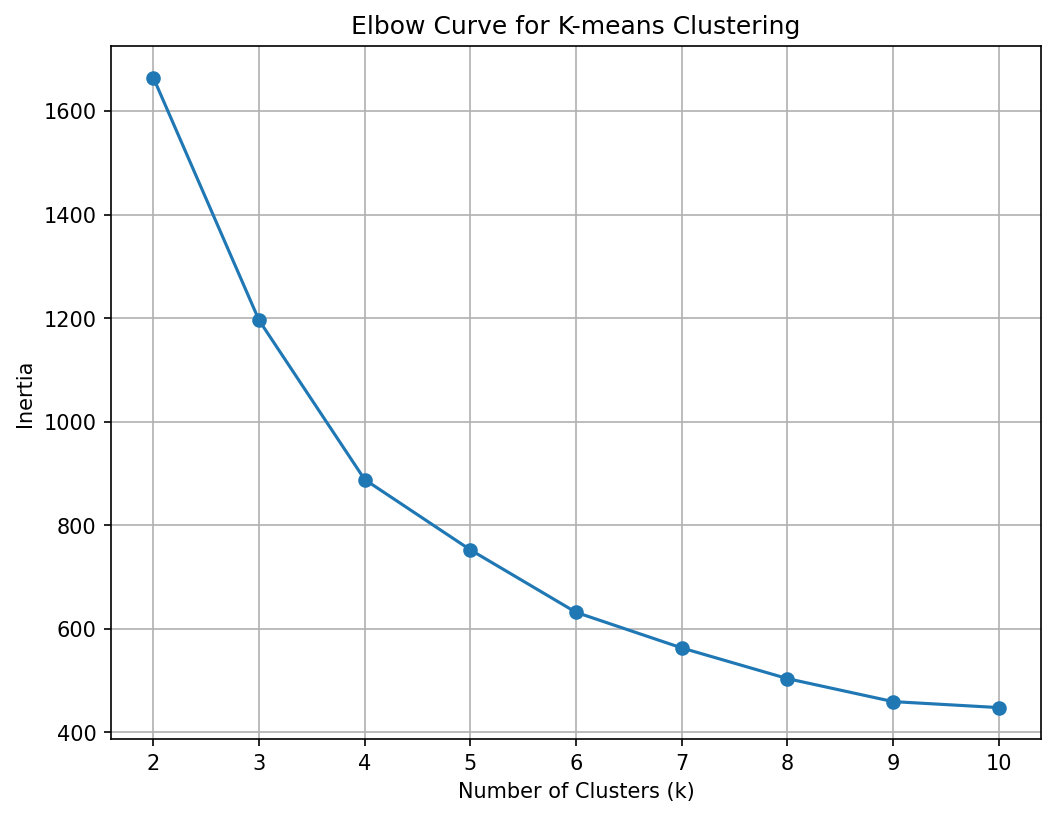

In [66]:
from sklearn.cluster import KMeans

# Calculate inertia (sum of squared distances) for different values of k
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init= 10, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6),dpi=150)
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

According to the elbow curve I will set the number of clusters K=4.

In [67]:
# Fit a K-means model to the whole dataset and cluster these segments:

In [68]:
# Perform K-means clustering with best K
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = best_kmeans.fit_predict(X)

In [69]:
# Group by cluster and calculate mean values
cluster_summary = rfm.groupby('Cluster').agg({
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).reset_index()

## Cluster interpretation:

In [70]:
cluster_summary

,Cluster,R_Score,F_Score,M_Score
0,0,4.447115,2.769231,2.052885
1,1,2.494792,3.234375,2.593750
2,2,1.775510,1.469388,1.142857
3,3,4.345946,4.335135,3.740541


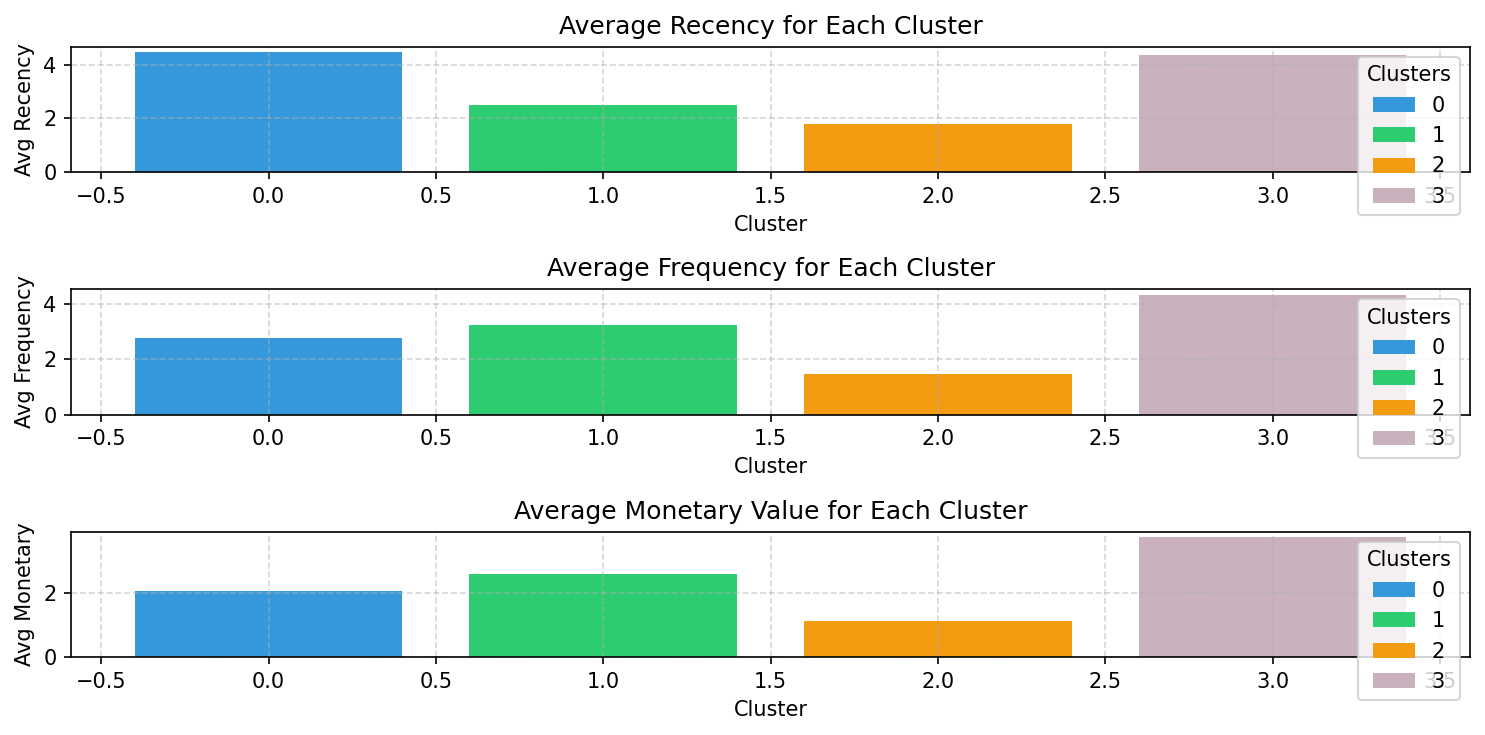

In [72]:
colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']#,'#f8c51d']

# Plot the average RFM scores for each cluster
plt.figure(figsize=(10, 5),dpi=150)

# Plot Avg Recency
plt.subplot(3, 1, 1)
bars = plt.bar(cluster_summary.index, cluster_summary['R_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Recency')
plt.title('Average Recency for Each Cluster')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Frequency
plt.subplot(3, 1, 2)
bars = plt.bar(cluster_summary.index, cluster_summary['F_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Frequency')
plt.title('Average Frequency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Monetary
plt.subplot(3, 1, 3)
bars = plt.bar(cluster_summary.index, cluster_summary['M_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Monetary')
plt.title('Average Monetary Value for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

plt.tight_layout()
plt.show()

Les characterize these behaviours according to the clusters.

Cluster 0: these are transactions that ocurred recently, with moderate frequency and with low ammounts of money per transaction. I will call these **" Recent-Eventual-Low"**.

Cluster 1: These shows low recency but with moderate frequenty and ammounts per transaction. I will name this group **"Low Recency-Frequent-Low Ammount"**.

Cluster 2: These are not recent transactions, with low frequency and ammount per transaction. I will call this group **"Not Recent-Eventual-Low"**.

Cluster 3: recent purchases with high frequency and larges ammounts per transaction. I will label this group as **Recent-Frequent-High**.

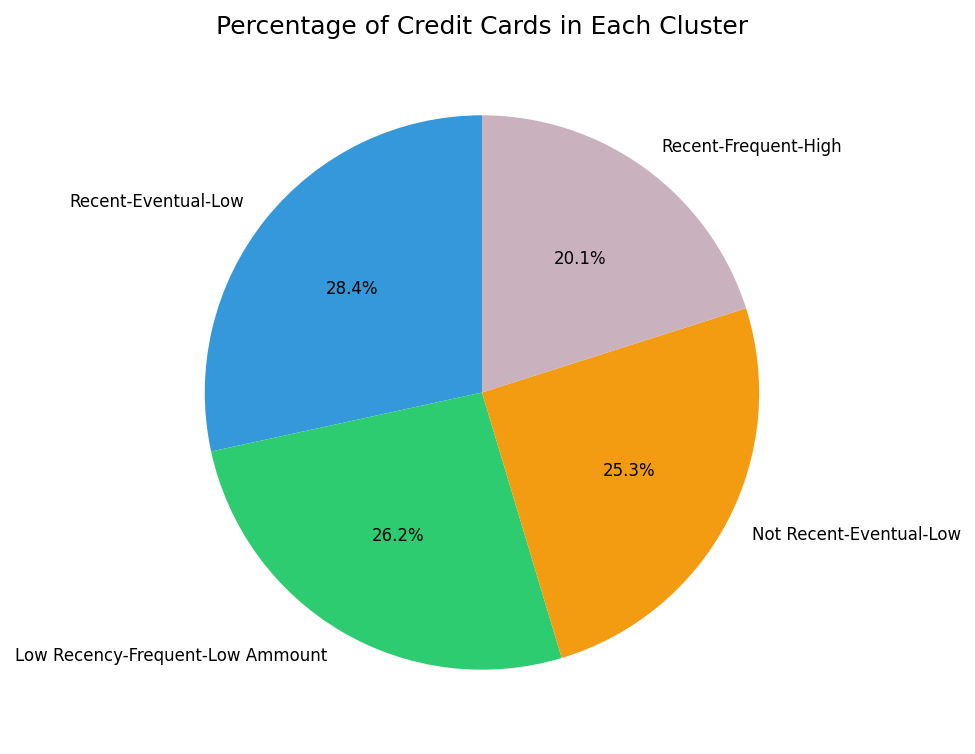

In [73]:
cluster_counts = rfm['Cluster'].value_counts()

colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']
# Calculate the total number of customers
total_customers = cluster_counts.sum()

# Calculate the percentage of customers in each cluster
percentage_customers = (cluster_counts / total_customers) * 100

labels = ['Recent-Eventual-Low','Low Recency-Frequent-Low Ammount','Not Recent-Eventual-Low','Recent-Frequent-High']#,'Recent-Frequent-High']

# Create a pie chart
plt.figure(figsize=(9, 6),dpi=150)
plt.pie(percentage_customers, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors,textprops={'fontsize': 8})
plt.title('Percentage of Credit Cards in Each Cluster')

plt.show()

According to this cluster modelling I recommend to focus particularly in the **Recent-Frequent-High** group of credit cards wich representates 20.1% of the total and investigate this particular group of transactions.

In [74]:
rfm

,Recency,Frequency,MonetaryValue,R_Score,F_Score,M_Score,Cluster
card_number,,,,,,,
************0031,288,1,99.58,1,1,1,2
************0037,10,9,3190.39,4,2,2,0
************0057,43,14,1470.07,3,3,2,1
************0065,30,100,14075.28,3,4,4,3
************0085,365,1,120.28,1,1,1,2
...,...,...,...,...,...,...,...
************9961,2,23,2806.99,5,3,2,0
************9979,4,150,12564.56,5,5,4,3
************9987,6,26,1728.98,5,3,2,0


## Forecasting:

I will forecast the global expenditures for a period of a month on a dayly approach.  

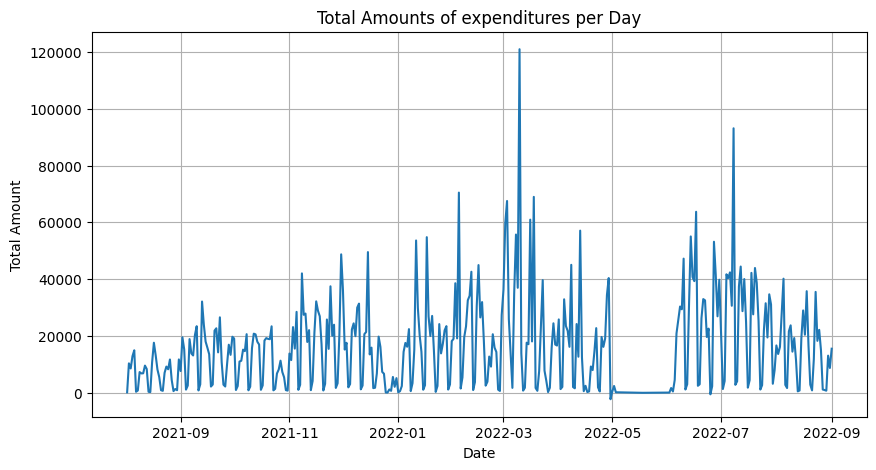

In [75]:
# We plot briefly the total ammounts of expenditures per day en the period considered:

import matplotlib.pyplot as plt

data_total[['trans_date','original_gross_amt']]

filtered_df = data_total[(data_total['trans_date'] >= '2021-08-01') & (data_total['trans_date'] <= '2022-09-01')]
grouped_df = filtered_df.groupby('trans_date')['original_gross_amt'].sum().reset_index()

# Graficar la serie temporal
plt.figure(figsize=(10, 5))
plt.plot(grouped_df['trans_date'], grouped_df['original_gross_amt'])
plt.title('Total Amounts of expenditures per Day')
plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.grid(True)
plt.show()

In the previous graphic we can see how varible the expenditures are in the period considered. We will use 12 months of data in order to forecast the next month, in this case modeling from August 2021 till July 2022 and then forecast August 2022 and evaluate metrics. This will be done in a with a monthly and dayly basis.

In a first overview I can identify a "weekly-seasonal" in exception of the period of October 2021 where there is no pattern. There is no clear tendency in the global expenditures. There are 3 peaks of total ammounts, the first during January 2022, the highest in March 2022 and a third peak in July 2022.   

Augmented Dickey-Fuller test:

The augmented Dickey-Fuller test considers as the null hypothesis that the time series has a unit root, a common characteristic of non-stationary time series. On the contrary, the alternative hypothesis (under which the null hypothesis is rejected) is that the series is stationary.

Null hypothesis (HO): The series has a unit root, it is not stationary.

Alternative hypothesis (HA): The series does not have a unit root, it is stationary.

Since the null hypothesis assumes the presence of a unit root, the p-value obtained must be less than a certain significance level, often set at 0.05, to reject this hypothesis. This result indicates the stationarity of the series. The adfuller() function of the Statsmodels library allows you to apply the ADF test. Its result includes four values: the p-value, the statistic value, the number of delays (lags) included in the test and the critical value thresholds for three different levels of significance.

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test.

The KPSS test tests whether a time series is stationary around a mean or a linear trend. In this test, the null hypothesis is that the series is stationary. Therefore, small p-values ​​(e.g., less than 0.05) reject the null hypothesis and suggest that differentiation is necessary. The Statsmodels library provides an implementation of the KPSS test through the kpss() function.

In [76]:
# Lets check stationarity:

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.seasonal import seasonal_

datos = grouped_df.set_index('trans_date')





datos_diff_1 = datos.diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Stationarity Test original serie')
print('-------------------------------------')
adfuller_result = adfuller(datos)
kpss_result = kpss(datos)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')



Stationarity Test original serie
-------------------------------------
ADF Statistic: -3.927835366101946, p-value: 0.0018392810297681937
KPSS Statistic: 1.1897635716955126, p-value: 0.01


<ipython-input-76-eca50ba44170>:22: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




According to ADF test with a p value of 0 we reject the null hypothesis for an \alpha=0.01 level of confidence and consider our this series Stationary. KPSS test p value is 0.01 wich is equal an \alpha=0.01 level of confidence thus we cannot reject the stationary hypothesis for this time series.

Text(0.5, 1.0, 'Partial autocorrelation')

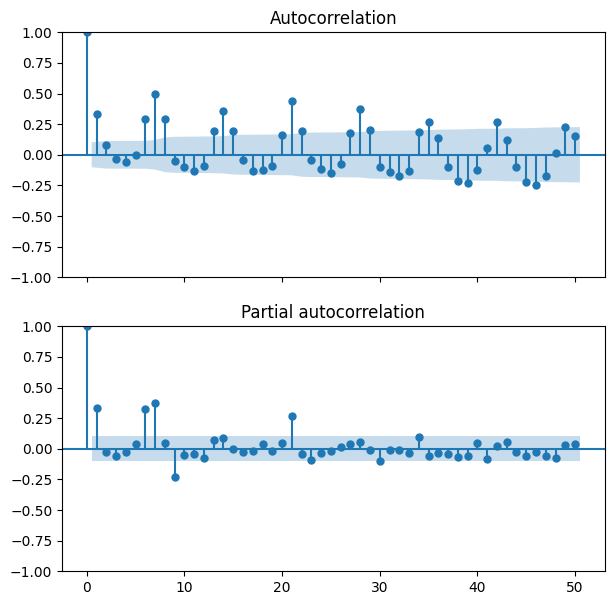

In [77]:
# Check autocorrelation and partial autocorrelation:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)
plot_acf(datos, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation')

plot_pacf(datos, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Partial autocorrelation')

This series presents autocorrelation patterns that are consistent with my first observation (Seasonal behaviour). Autocorrelation with significant coefficients in lags that are multiplies of 7 and partial autocorrelation showing patterns also in the first, seventh eight lags.


Text(0.5, 1.0, 'Residual')

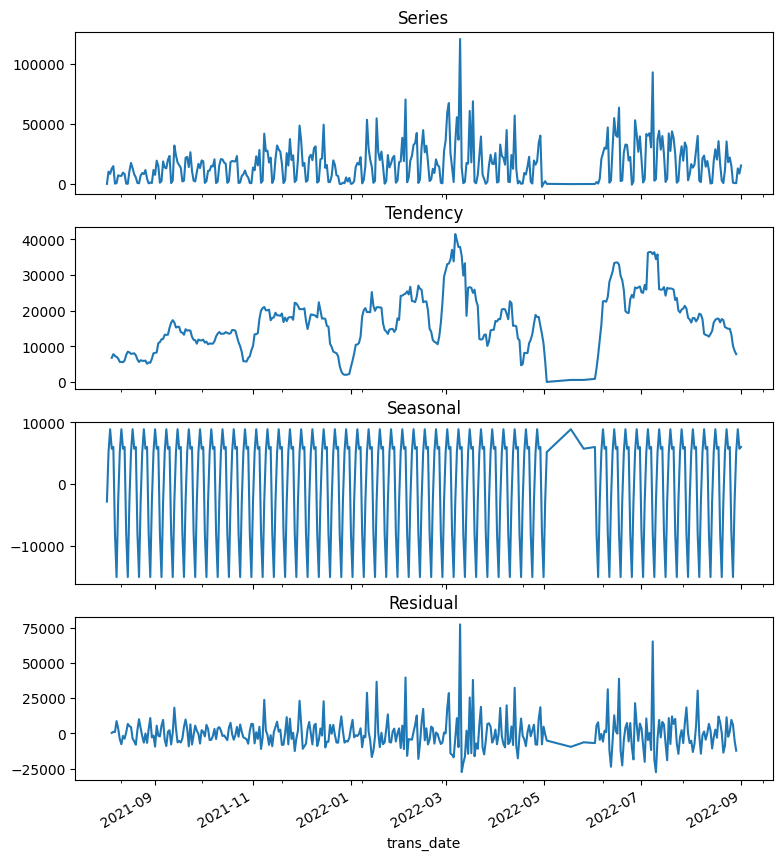

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose



res_decompose = seasonal_decompose(datos, model='additive',period=7)

fig, axs = plt.subplots(nrows=4, figsize=(9, 11), sharex=True)
res_decompose.observed.plot(ax=axs[0])
axs[0].set_title('Series')
res_decompose.trend.plot(ax=axs[1])
axs[1].set_title('Tendency')
res_decompose.seasonal.plot(ax=axs[2])
axs[2].set_title('Seasonal')
res_decompose.resid.plot(ax=axs[3])
axs[3].set_title('Residual')

In an additive decomposition it is clear that there is a weeky seasonal in this data and the series has a mean level around 20000 GBP. Residuals have mean zero and certain peaks, corresponding to outliers.

# SARIMA forecasting

In [79]:
datos

,original_gross_amt
trans_date,
2021-08-02,103.85000
2021-08-03,10330.84224
2021-08-04,8514.56200
2021-08-05,12849.01000
2021-08-06,14918.90000
...,...
2022-08-28,916.48818
2022-08-29,689.81000
2022-08-30,13034.18000


Text(0, 0.5, 'Expenditure')

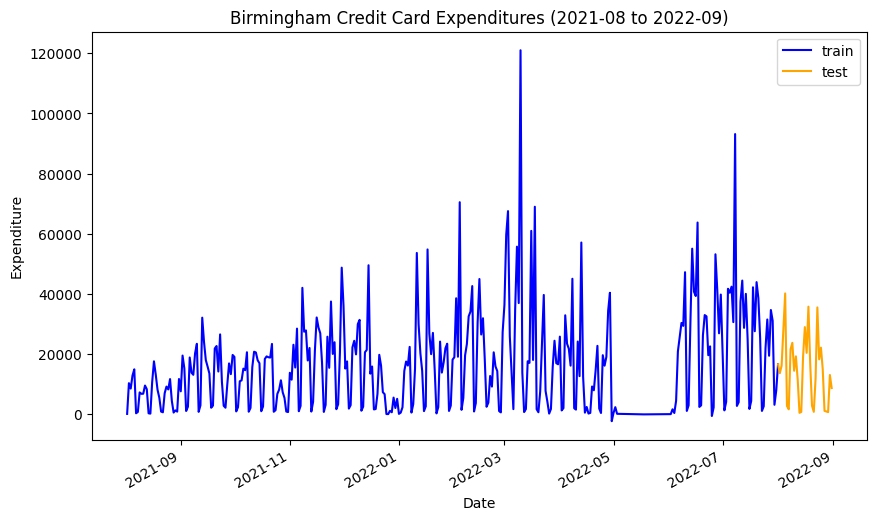

In [80]:
# Fechas Train-test
# ======================================================================================
fin_train = '2022-08-01'

datos_train = datos.loc[:fin_train]
datos_test  = datos.loc['2022-08-01':'2022-08-31']

datos_train.rename(columns={'original_gross_amt': 'train'}, inplace=True)
datos_test.rename(columns={'original_gross_amt': 'test'}, inplace=True)


# Gráfico
# ======================================================================================
fig, ax = plt.subplots(figsize=(10, 6))  # Ajusta el tamaño del gráfico según tus necesidades
datos_train.plot(ax=ax, label='Training Data', color='blue')
datos_test.plot(ax=ax, label='Testing Data', color='orange')
ax.set_title('Birmingham Credit Card Expenditures (2021-08 to 2022-09)')
ax.set_xlabel('Date')
ax.set_ylabel('Expenditure')

In [81]:
#Sarimax with Statsmodels:


modelo = SARIMAX(endog = datos_train, order = (1, 0, 1), seasonal_order = (1, 0, 1, 7),enforce_stationarity=False,enforce_invertibility=False)
modelo_res = modelo.fit(disp=0)
modelo_res.summary()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             train   No. Observations:                  338
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -3607.793
Date:                           Tue, 23 Jul 2024   AIC                           7225.585
Time:                                   01:54:48   BIC                           7244.565
Sample:                                        0   HQIC                          7233.157
                                           - 338                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8798      0.102      8.664      0.000       0.681       1.079
ma.L1         -0.7134      0.133     -5.360      0.000      -0.974      -0.453
ar.S.L7        0.9977      0.022     45.858      0.000       0.955       1.040
ma.S.L7       -0.8119      0.046    -17.549      0.000      -0.903      -0.721
sigma2      2.955e+08   3.69e-10   8.02e+17      0.000    2.96e+08    2.96e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):               976.08
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               5.90   Skew:                             1.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

The model summary shows a lot of information about the fitting process:

Model Fit Statistics: This part includes several statistics that help evaluate how well the model fits the observed data:

Log-Likelihood: A measure of how well the model explains the observed data, with more negative values indicating a poor fit to the data and values closer to zero indicating a better fit. In this case with not a particular good fit.

AIC (Akaike Information Criterion): A goodness-of-fit metric that balances model fit with its complexity. The lower the AIC value, the better the model.

BIC (Bayesian Information Criterion): Similar to AIC, but penalizes the complexity of the model more. As with the AIC, lower BIC values indicate a better fit.

HQIC (Hannan-Quinn Information Criterion): Another model selection criterion, similar to AIC and BIC.

Coefficients: This table lists the estimated coefficients for the model parameters. It includes both autoregressive (AR) and moving average (MA) parameters, as well as any exogenous variables if they are included in the model. It also includes the standard errors associated with the estimated coefficients to indicate the uncertainty of those estimates, their p-values, which are used to evaluate the significance of each coefficient, and the 95% confidence interval. In this case all coefficients are singnificative.

Model Diagnostics: This section provides information about the residuals. The differences between the observed values (training values) and the values predicted by the model.

Ljung-Box test: A test for autocorrelation in the residuals.

Jarque-Bera test: A test of normality of residuals. In this case residuals seem not to be normal.

Skewness and kurtosis: Measures of the shape of the distribution of residuals.

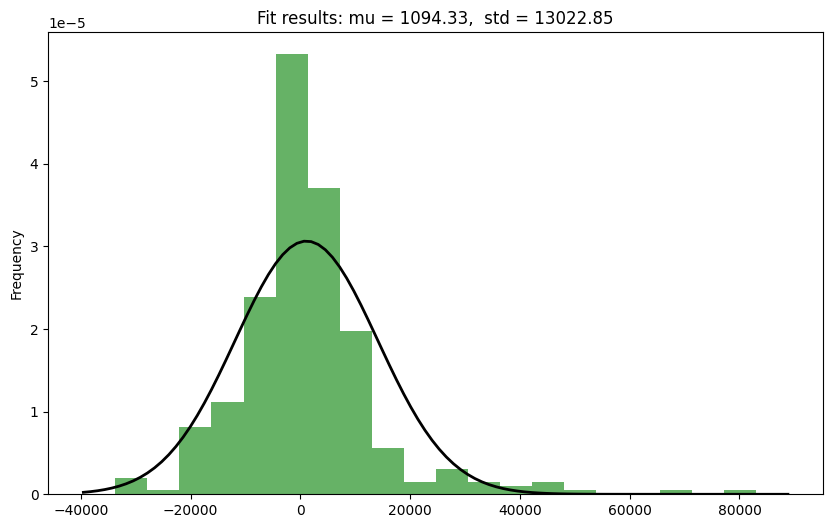

In [82]:
import numpy as np
from scipy.stats import norm

residuals = modelo_res.resid

# Plot histogram of residuals
plt.figure(figsize=(10, 6))
ax = residuals.plot(kind='hist', bins=20, density=True, alpha=0.6, color='g')

# Fit a normal distribution to the residuals
mu, std = norm.fit(residuals)

# Plot the normal distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

title = f"Fit results: mu = {mu:.2f},  std = {std:.2f}"
plt.title(title)

plt.show()



Residuals presents Leptokurtic behaviour

# Forecast with SARIMA

In [83]:
predicciones_statsmodels = modelo_res.get_forecast(steps=len(datos_test)).predicted_mean
predicciones_statsmodels.name = 'SARIMA (1,0,1) (1,0,1)(7) predictions'
display(predicciones_statsmodels.head(30))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



338    31002.264002
339    27534.312224
340    30316.392597
341    29092.491795
342      230.325275
343     4787.608040
344    26945.676731
345    31900.919554
346    28324.298937
347    30997.195334
348    29685.789104
349      811.339921
350     5288.079294
351    27333.029244
352    32222.609290
353    28606.701334
354    31231.483765
355    29886.278545
356     1046.644284
357     5484.436758
358    27452.960893
359    32309.079936
360    28682.171124
361    31283.756178
362    29926.652479
363     1140.949808
364     5556.775285
365    27463.909852
366    32299.717386
367    28673.333055
Name: SARIMA (1,0,1) (1,0,1)(7) predictions, dtype: float64

Now I will plot these predictions with the original data and evaluate some metrics.

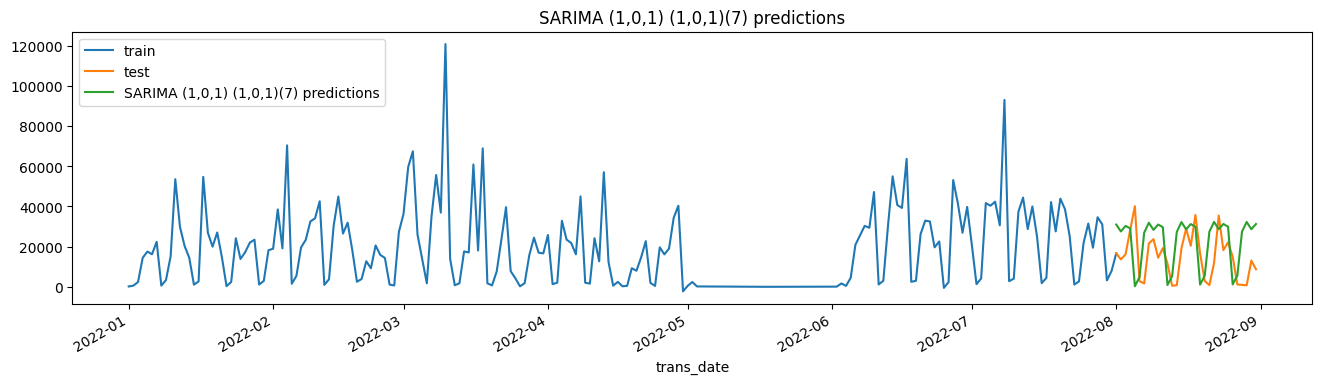

In [84]:
# Plot predictions
# ==============================================================================

df_forecast = pd.DataFrame(predicciones_statsmodels)
date_range = pd.date_range(start='2022-08-01', end='2022-08-31')
df_forecast.index = date_range
fig, ax = plt.subplots(figsize=(16, 4))
datos_train['2022-01-01':].plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
df_forecast.plot(ax=ax, label='SARIMA (1,0,1) (1,0,1)(7) predictions')
ax.set_title('SARIMA (1,0,1) (1,0,1)(7) predictions')
ax.legend();


In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Metrics:

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(datos_test['test'], df_forecast['SARIMA (1,0,1) (1,0,1)(7) predictions']))
print(f"RMSE: {rmse.round(4)}")

# Calcular MAE
mae = mean_absolute_error(datos_test['test'], df_forecast['SARIMA (1,0,1) (1,0,1)(7) predictions'])
print(f"MAE: {mae.round(4)}")

# Calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(datos_test['test'], df_forecast['SARIMA (1,0,1) (1,0,1)(7) predictions'])
print(f"MAPE: {mape.round(4)}")

RMSE: 16889.9286
MAE: 13945.6505
MAPE: 621.1489
